In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from tqdm import tqdm_notebook
from tqdm import tnrange

In [2]:
train_x_list = "D:/Study/自学项目/人类活动识别/UCI_data/np/x_train.npy"
train_y_list = "D:/Study/自学项目/人类活动识别/UCI_data/np/y_train.npy"
test_x_list = "D:/Study/自学项目/人类活动识别/UCI_data/np/x_test.npy"
test_y_list = "D:/Study/自学项目/人类活动识别/UCI_data/np/y_test.npy"

data_x_raw = np.load(train_x_list)
trainx = data_x_raw.reshape(-1, 1, data_x_raw.shape[1], data_x_raw.shape[2])
trainy = np.load(train_y_list)

In [3]:
trainx.shape

(7352, 1, 128, 9)

# Few-shot learning

In [4]:
def extract_sample(n_way, n_support, n_query, datax, datay):
    #Randomly pick up sample
    #n_wany means the number of classes
    #n_support means the number of labeled samples per class in the support set
    #n_query means the number of labeled samples per class in the query set

    sample = []
    K = np.random.choice(np.unique(datay), n_way, replace=False)
    for cls in K:
        datax_cls = datax[datay == cls]
        perm = np.random.permutation(datax_cls)
        sample_cls = perm[:(n_support+n_query)]
        sample.append(sample_cls)
    sample = np.array(sample)
    sample = torch.from_numpy(sample).float()
    return({
      'sample': sample,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })
sample = extract_sample(5, 20, 5, trainx, trainy)
sample = sample['sample']
sample.shape

torch.Size([5, 25, 1, 128, 9])

In [5]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
    x_dim = kwargs['x_dim']
    hid_dim = kwargs['hid_dim']
    z_dim = kwargs['z_dim']

    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
    
    def conv_block2(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            )


    encoder = nn.Sequential(
    conv_block(1, 12),
    conv_block(12, 32),
    conv_block2(32, z_dim),
    Flatten()
    )

    return ProtoNet(encoder)
     


In [6]:
class ProtoNet(nn.Module):
    def __init__(self, encoder):
        super(ProtoNet, self).__init__()
        self.encoder = encoder

    def set_forward_loss(self, sample):
        sample_images = sample['sample']
        n_way = sample['n_way']
        n_support = sample['n_support']
        n_query = sample['n_query']

        x_support = sample_images[:, :n_support]
        x_query = sample_images[:, n_support:]

        target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
        target_inds = Variable(target_inds, requires_grad=False)
        target_inds = target_inds

        #encode images of the support and the query set
        x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                       x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)
        
        #use CNN to encode the dataset
        z = self.encoder.forward(x)
        z_dim = z.size(-1)
        z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
        z_query = z[n_way*n_support:]

        #compute distances
        dists = euclidean_dist(z_query, z_proto)

        #compute probabilities
        log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

        loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
        _, y_hat = log_p_y.max(2)
        acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

        return loss_val, {
            'loss': loss_val.item(),
            'acc': acc_val.item(),
            'y_hat': y_hat
            }


In [7]:
def euclidean_dist(x, y):
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)
     

In [29]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):

    scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
    epoch = 0 
    stop = False 
    alllose = []
    allacc = []
    
    while epoch < max_epoch and not stop:
        running_loss = 0.0
        running_acc = 0.0
        
        for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
            sample = extract_sample(n_way, n_support, n_query, train_x, train_y)
            optimizer.zero_grad()
            loss, output = model.set_forward_loss(sample)
            running_loss += output['loss']
            running_acc += output['acc']
            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / epoch_size
        epoch_acc = running_acc / epoch_size
        alllose.append(epoch_loss)
        allacc.append(epoch_acc)
        print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
        epoch += 1
        scheduler.step()
     
    return list(model.named_parameters()), alllose,allacc

# Few-shot learning with Federated learning

I assume there are two independent servers and they both have some dataset. To protect the privacy of their data, i use the federated learning instead of getting their data. There i send two same models to these two servers from a safe server, and then they train a model respectively. Then two server will send the weights and biases back to the safe server and calculte a average weight and bias. Finally, put the average parameters into a new model same as above two and use this model to test.   

## Model A

This is the server A and it have half of dataset. The pral_a is the weight and bias after training.

In [30]:
data_a_x = trainx[:3600]
data_a_y = trainy[:3600]

model = load_protonet_conv(x_dim=(1,128,9),
    hid_dim=32,
    z_dim=64,
            )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 10
n_query = 5

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 3600

pra1_a,al_a,ac_a = train(model, optimizer, data_a_x, data_a_y, n_way, n_support, n_query, max_epoch, epoch_size)

D:\Anaconda\envs\syft\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  del sys.path[0]


Epoch 1 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.1022 Acc: 0.9535


Epoch 2 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0583 Acc: 0.9731


Epoch 3 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0444 Acc: 0.9807


Epoch 4 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0381 Acc: 0.9842


Epoch 5 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0328 Acc: 0.9865


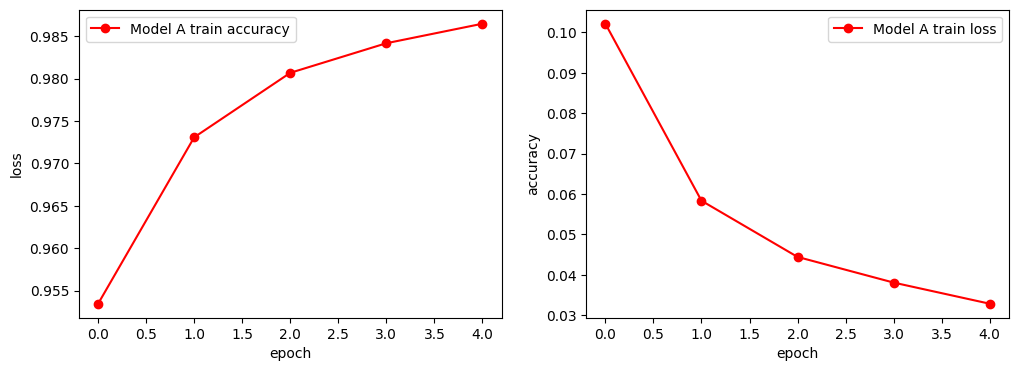

In [32]:
e = np.arange(5)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(e,ac_a,"ro-",label="Model A train accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(e,al_a,"ro-",label="Model A train loss")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Model B

This is the servr B and it have another half of dataset. The pral_b is the weight and bias after training.

In [33]:
data_b_x = trainx[3600:]
data_b_y = trainy[3600:]

model = load_protonet_conv(x_dim=(1,128,9),
    hid_dim=32,
    z_dim=64,
            )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 5
n_support = 10
n_query = 5

max_epoch = 5
epoch_size = 3600

pra1_b,al_b,ac_b = train(model, optimizer, data_b_x, data_b_y, n_way, n_support, n_query, max_epoch, epoch_size)

D:\Anaconda\envs\syft\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  del sys.path[0]


Epoch 1 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 1 -- Loss: 0.0672 Acc: 0.9731


Epoch 2 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 2 -- Loss: 0.0222 Acc: 0.9907


Epoch 3 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 3 -- Loss: 0.0122 Acc: 0.9952


Epoch 4 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 4 -- Loss: 0.0077 Acc: 0.9971


Epoch 5 train:   0%|          | 0/3600 [00:00<?, ?it/s]

Epoch 5 -- Loss: 0.0056 Acc: 0.9979


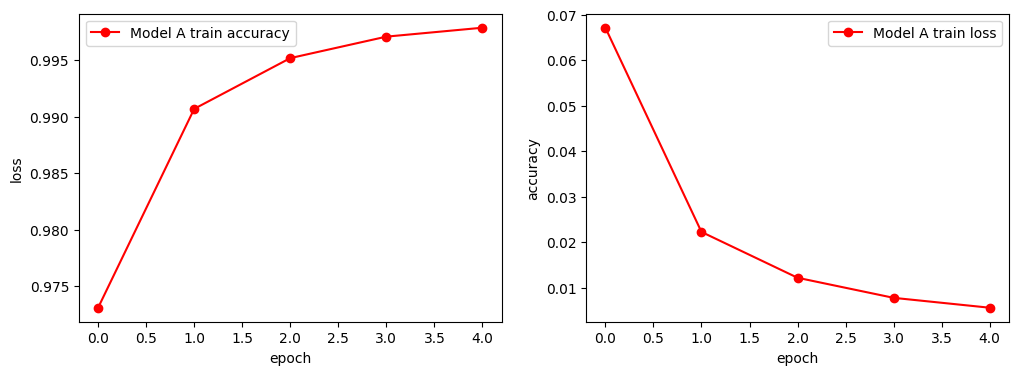

In [34]:
e = np.arange(5)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(e,ac_b,"ro-",label="Model A train accuracy")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.subplot(1,2,2)
plt.plot(e,al_b,"ro-",label="Model A train loss")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Extract the parameters

Get the parameters back and then calculate the average of them

In [35]:
def combine_params(para_A,para_B):
    c1_wA=para_A[0][1].data
    c1_wB=para_B[0][1].data
  
    c2_wA=para_A[2][1].data
    c2_wB=para_A[2][1].data
    
    c3_wA=para_A[4][1].data
    c3_wB=para_B[4][1].data


    com_para_c1=(c1_wA+c1_wB)/2
    com_para_c2=(c2_wA+c2_wB)/2
    com_para_c3=(c3_wA+c3_wB)/2
        
    return com_para_c1,com_para_c2,com_para_c3


def combine_params_bias(para_A,para_B):
    c1_wA=para_A[1][1].data
    c1_wB=para_B[1][1].data
  
    c2_wA=para_A[3][1].data
    c2_wB=para_A[3][1].data
    
    c3_wA=para_A[5][1].data
    c3_wB=para_B[5][1].data


    com_para_c1=(c1_wA+c1_wB)/2
    com_para_c2=(c2_wA+c2_wB)/2
    com_para_c3=(c3_wA+c3_wB)/2
        
    return com_para_c1,com_para_c2,com_para_c3

Rebuild a safe server and then add the parameters into the model

In [36]:
def load_protonet_conv2(com_para_c1,com_para_c2,com_para_c3,com_para_c1b,com_para_c2b,com_para_c3b):

    def conv_block1(in_channels,out_channels,com_para):
        c = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        c.weight=Parameter(com_para)
        return nn.Sequential(
            c,
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
    
    def conv_block2(in_channels, out_channels,com_para):
        c = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        c.weight=Parameter(com_para)
        return nn.Sequential(
            c,
            nn.ReLU(),
            )


    encoder = nn.Sequential(
    conv_block1(1, 12,com_para_c1),
    conv_block1(12, 32,com_para_c2),
    conv_block2(32, 64,com_para_c3),
    Flatten()
    )

    return ProtoNet(encoder)

In [37]:
com_para_c1,com_para_c2,com_para_c3 = combine_params(pra1_a,pra1_b)
com_para_c1b,com_para_c2b,com_para_c3b = combine_params_bias(pra1_a,pra1_b)
final_model = load_protonet_conv2(com_para_c1,com_para_c2,com_para_c3,com_para_c1b,com_para_c2b,com_para_c3b)

In [38]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
    running_loss = 0.0
    running_acc = 0.0
    for episode in tnrange(test_episode):
        sample = extract_sample(n_way, n_support, n_query, test_x, test_y)
        loss, output = model.set_forward_loss(sample)
        running_loss += output['loss']
        running_acc += output['acc']
    avg_loss = running_loss / test_episode
    avg_acc = running_acc / test_episode
    print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))


In [39]:
test_x_list = "D:/Study/自学项目/人类活动识别/UCI_data/np/x_test.npy"
test_y_list = "D:/Study/自学项目/人类活动识别/UCI_data/np/y_test.npy"

data_x_raw = np.load(test_x_list)
testx = data_x_raw.reshape(-1, 1, data_x_raw.shape[1], data_x_raw.shape[2])
testy = np.load(test_y_list)

n_way = 5
n_support = 10
n_query = 5

test_episode = 1000
test(final_model, testx, testy, n_way, n_support, n_query, test_episode)

D:\Anaconda\envs\syft\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


  0%|          | 0/1000 [00:00<?, ?it/s]

Test results -- Loss: 1.1876 Acc: 0.6284
